# xHash challenge

## 1. Code for first question

I'm going to do separate functions to have a modular build of this task

### 1.1 Exchange rate time series

In [2]:
import ast
import requests

In [194]:
def get_ts_rates(base='USD',target='MXN',start_at = '2018-01-01', end_at = '2018-09-01'):
    # calls the exchangeratesapi API for time series data with parameters:
    
    # base,target - base and target currency
    # start_at, end_at - time window in format %Y-%m-%d
    
    # returns a dictionary with the time series data
        
    url = 'https://api.exchangeratesapi.io/history?start_at={}&end_at={}&base={}&symbols={}'.format(start_at,end_at,base,target)
    response = requests.get(url)
    rates = ast.literal_eval(response.content.decode('utf-8'))
    rates = rates['rates']
    return([elem['MXN'] for elem in rates.values()])

In [163]:
ts = get_ts_rates()

### 1.2 fitting auto.arima model with information_criterion='bic'

In [75]:
from pmdarima.datasets import load_lynx
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import random

In [171]:
# Fit a simple auto_arima model using library pmdarima
random.seed(420)
model = auto_arima(y=np.asarray(ts), information_criterion='bic', seasonal=True,
                   suppress_warnings=True,error_action='ignore')

### 1.3 forecast with 95% confidence interval

In [172]:
# Create predictions for the future, evaluate on test
preds, conf_int = model.predict(n_periods=30, return_conf_int=True)

In [173]:
# why is it constant? -> https://stats.stackexchange.com/questions/135651/arima-predictions-constant
preds

array([19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398,
       19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398,
       19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398,
       19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398,
       19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398,
       19.05165398, 19.05165398, 19.05165398, 19.05165398, 19.05165398])

### 1.4 plot

In [185]:
import datetime
start_at = '2018-01-01'
n_predictions = 30
x = [datetime.datetime.strptime(start_at, "%Y-%m-%d").date() + datetime.timedelta(days=i) 
     for i in range(len(ts) + n_predictions)]
y = np.append(np.asarray(ts),preds)
x1 = [elem[0] for elem in conf_int]
x2 = [elem[1] for elem in conf_int]

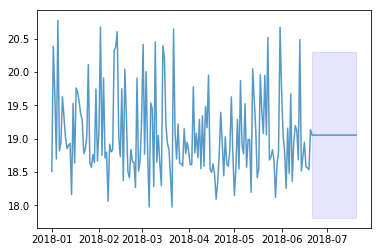

In [186]:
plt.plot(x,y, alpha=0.75)
plt.fill_between(x[-30:],
                 x1, 
                 x2,
                 color='b', alpha=.1)


## all together

In [197]:
def xhash_1(base='USD',target='MXN',start_at = '2018-01-01', end_at = '2018-09-01',n_predictions = 30):
    # base,target - base and target currency
    # start_at, end_at - time window in format %Y-%m-%d
    # n_predictions - number of days to predict
    
    # 1.1 we do the api call to get time series exchange data
    ts = get_ts_rates(base='USD',start_at = '2018-01-01', end_at = '2018-09-01',target='MXN')
    
    # 1.2 we fit an auto.arima model with bic
    random.seed(420)
    model = auto_arima(y=np.asarray(ts), information_criterion='bic', seasonal=True,
                   suppress_warnings=True,error_action='ignore')
    
    # 1.3 give predictions and confidence intervals
    preds, conf_int = model.predict(n_periods=n_predictions, return_conf_int=True)
    
    # 1.4 Output a plot as requested
    x = [datetime.datetime.strptime(start_at, "%Y-%m-%d").date() + datetime.timedelta(days=i) 
     for i in range(len(ts) + n_predictions)]
    y = np.append(np.asarray(ts),preds)
    x1 = [elem[0] for elem in conf_int]
    x2 = [elem[1] for elem in conf_int]
    plt.plot(x,y, alpha=0.75)
    plt.fill_between(x[-30:], x1, x2, color='g', alpha=.1)
    
    #returns predictions and confidence intervals
    return((preds,conf_int))

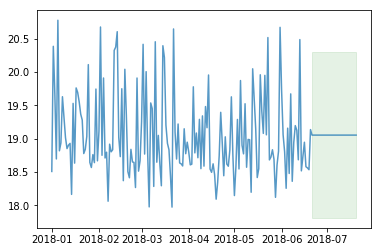

In [199]:
# example with default values
preds,conf_int = xhash_1()

## 2. Code for second question

In [ ]:
import pandas as pd

df = pd.read_csv('encu/TR_VIVIENDA01.CSV',encoding = 'latin1')

for i in range(31):
    if i < 8:
        df = df.append(pd.read_csv('encu/TR_VIVIENDA0{}.CSV'.format(i+2),encoding = 'latin1'))
    else:
        df = df.append(pd.read_csv('encu/TR_VIVIENDA{}.CSV'.format(i+2),encoding = 'latin1'))
    #print(i+2)


In [58]:
df['IS_ADOBE'] = (df.PAREDES == 7)
df['adobe'] = df['IS_ADOBE'] * df['FACTOR']

In [61]:
vivs = df.groupby('NOM_MUN')['FACTOR'].sum()

adobe = df.groupby('NOM_MUN')['adobe'].sum()

In [63]:
perc_adobe = [adobe[i] / vivs[i] for i in range(len(adobe))]

In [68]:
perc_adobe.index(max(perc_adobe))

1400

In [82]:
vivs[[1400]]

NOM_MUN
San Juan de Guadalupe    1435
Name: FACTOR, dtype: int64

El municipio con el mayor porcentaje de casas de adobe es San Juan de Guadalupe, Durango.

In [83]:
df['is_renta'] = (df.TENENCIA == 2)
df['renta'] = df['is_renta'] * df['FACTOR']

renta = df.groupby('NOM_MUN')['renta'].sum()

perc_renta = [renta[i] / vivs[i] for i in range(len(adobe))]

vivs[[perc_renta.index(max(perc_renta))]]

NOM_MUN
Solidaridad    68630
Name: FACTOR, dtype: int64

El municipio con el mayor porcentaje de viviendas que paga renta es Solidaridad, Quintana Roo

In [87]:
df['is_mujer'] = (df.JEFE_SEXO == 3)
df['mujer_jefa'] = df['is_mujer'] * df['FACTOR']

jefas = df.groupby('NOM_MUN')['mujer_jefa'].sum()

perc_mujer = [jefas[i] / vivs[i] for i in range(len(jefas))]

vivs[[perc_mujer.index(max(perc_mujer))]]

NOM_MUN
San Miguel Tulancingo    101
Name: FACTOR, dtype: int64

El municipio con el mayor porcentaje de vivienas dónde la jefa de familia es mujer es San Miguel Tulancingo Oaxaca

## 3 Code for third question

In [148]:
# function that opens a txt file and overwrites capitals to lower and nN to ñÑ

def xHash_3(filename):
    # read txt while replacing string atributes
    with open(filename, 'r') as myfile:
        data=myfile.read().lower().replace('n', 'ñ')

    myfile.close()
    
    # write requested items in modFILENAME.txt
    with open('mod' + filename , 'w') as myfile:
        myfile.write(data)

    myfile.close()

In [149]:
xHash_3('poem.txt')

## 4 Code for fourth question

$(\{x : (x − \bar{x})^tS^{−1}(x − \bar{x}) ≤ 1\})$

In [125]:
def ellipse(x,y,mat):
    return np.matmul(np.matmul([x,y],np.linalg.inv(mat)),[x,y]) <=1

In [140]:
import numpy as np
import matplotlib.pyplot as plt


def xHash4(x=0,y=0,mat=[[5,4],[4,5]]):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    z = np.array([ellipse(i,j,mat) for j in y for i in x])

    X, Y = np.meshgrid(x, y)

    Z = z.reshape(100, 100)

    plt.contourf(X, Y, Z)
    plt.show()
    
    vaps,veps = np.linalg.eig(np.linalg.inv(mat))
    print('la longitud del eje mayor es {}'.format(2*float(1/np.sqrt(vaps[1]))))
    print('la longitud del eje menor es {}'.format(2*float(1/np.sqrt(vaps[0]))))  

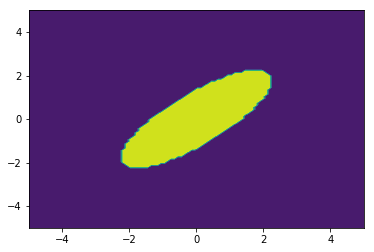

la longitud del eje mayor es 5.999999999999998
la longitud del eje menor es 2.0


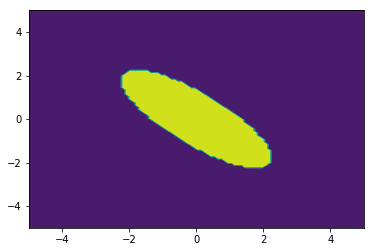

la longitud del eje mayor es 5.999999999999998
la longitud del eje menor es 2.0


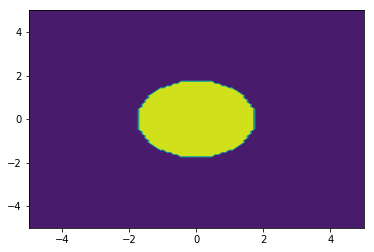

la longitud del eje mayor es 3.464101615137755
la longitud del eje menor es 3.464101615137755


In [141]:
xHash4()
xHash4(mat = [[5,-4],[-4,5]])
xHash4(mat = [[3,0],[0,3]])